# Interpreting implicit feedback data for expert systems



Plan: 


0.5) Clean code of rank monitor (Work-ahead for the logging of next sprint)

1) Accurately Interpreting Clickthrough Data as Implicit Feedback (SIGIR 2016 Test Of Time Award)
	

	Trust bias   - > Bias to 'trust' engine click first reult
	Quality Bias - > If the relevance of the retrieved results decreases, 
			 users click on abstracts that are on average
		         less relevant

	Example set = S1 = {l1,. .. l7}
	
	S1 =    l1* l2 l3* l4 l5* l6 l7

	5 Strategies. 
	Click > Skip Above, 
	Last Click > Skip Above, 
	Click > Earlier Click, 
	Click > Skip Previous, 
	Click > No Click Next

2) Relative rankings to gold-set list
	2.1 Take set from SearchText that have been queried for ~200 or more times.
	2.2 Implement methodology from above paper.
	2.3 Implement graph methodology from other paper that builds on 1. 
		2.3.1 Construct graph of relevance paths. 
		2.3.2 Find largest connected graph. 

3) Delphi Questionnaires
	Does this approach match with what Delphi Questionaire would give us. 



</b>



To get a faceted search:

# Facet Search: 

http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?facet.field=SearchText&facet.mincount=200&facet=on&indent=on&q=EventID:164%20UserID:*&rows=0&wt=jsonueyr

http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?facet.field=SearchText&facet.mincount=200&facet=on&indent=on&q=EventID:164%20UserID:*%20AND%20ShortTimeStamp:[20181201%20TO%2020201201]&rows=0&wt=jsonueyr

De query: "unieke test query"
Aangeklikt: [3, 5, 7 17]  ->  (18-06-2019)
Aangeklikt: [1,10]        ->  (18-06-2019) +5 min later
Aangeklikt: [1,3,7]       ->  (18-06-2019) +25 min later
Aangeklikt: [2,2,7,8]     ->  (21-06-2019) ~ 15:25

De query: "Unieke test query"
TO DO Aangeklikt: [1, 10]       ->  (21-06-2019) ~ 15:33 Maar later dan



De Query: "test information retrieval"
Aangeklikt: [2, 5, 8, 26] ->  (18-06-2019)
Aangeklikt: [4, 12]       ->  (18-06-2019) + 5 min later
Aangeklikt: [1, 2, 5]     ->  (18-06-2019) +25 min later
Aangeklikt: [3, 4, 13]     ->  (21-06-2019) (15:33)

In [11]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os
import itertools

from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime
import datetime
from datetimerange import DateTimeRange
from datetime import timedelta  
from  dateutil import parser


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 30)



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Graph-building packages
import community
import networkx as nx
import matplotlib.pyplot as plt

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

# Request dataframe from solr

In [12]:
def request_into_dataframe(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    print(url)
    
    response = requests.get(url)
    
    # Transform the request into a json
    response = response.json()
    response = response['response']['docs']
     
    return pd.DataFrame(response)
     
    

In [13]:
def get_27_frame(rows=100000000, from_disk=True) -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 12-2018
    :param rows: query string
    :return:
    """
    
    if from_disk:
        return pd.read_hdf('./data_rank/df27_full')
    
    else:
        df_27_bitcoin = request_into_dataframe(rows=rows, query='EventID:27 AND DocumentPosition:*')
        df_27_bitcoin.to_hdf('./data_rank/df27_full', key='test', mode='w')
        
    return df_27_bitcoin 
 

def get_16_frame(search_text = '*', rows=1000000000) -> pd.DataFrame:
    """
    Get every search log from people with a UserID:* 
    :param search_text: query string
    :param rows: number of rows to get
    :return: 
    """
    
   
    df_164_bitcoin = request_into_dataframe(query='EventID:164 AND ShortTimeStamp:[20181201 TO 20201201] AND UserID:* AND SearchText:"{}" \
                                                        '.format(search_text,search_text), rows = rows)     
    
    if search_text != search_text.lower():
        df_164_bitcoin_lowercase = request_into_dataframe(query='EventID:164 AND ShortTimeStamp:[20181201 TO 20201201] AND UserID:* AND SearchText:"{}" \
                                                            '.format(search_text.lower(),search_text.lower()), rows = rows)     
        df = pd.concat([df_164_bitcoin, df_164_bitcoin_lowercase])
    else:
        df = df_164_bitcoin
    
    
#     try:
#         # Keep only filterpath is NaN so only searches regular engine ie. no filtered searches. 
#         df = df[pd.isna(df['FilterPath'])]
#     except ValueError:
#         print('Empty dataframe')
        
    # Inster an empty column with to be filled document positions 
    df['DocumentPosition'] = df.progress_apply(lambda x: [], axis=1)
    
    df.to_hdf('./multiple_query/df164_full', key='test', mode='w')

    return df


# get_16_frame('unieke test query', rows=1000)



In [14]:
def list_currentdir():
    """
    Helper function to print contents of current directory and /data/ dir.
    """
    currentdir = Path('./data/')
    display([file for file in currentdir.glob('*')])
    display([file for file in Path('./').glob('*')])
    display([file for file in Path('./multiple_query/').glob('*')])


# list_currentdir()

In [15]:
def check_in_timerange(timestamp : datetime.datetime, query = pd.DataFrame, df_27 = pd.DataFrame) -> list:
    """
    Check if the there are clickedobjects within + and - 5 minutes from the query
    timestamp: object from the dateutil parser library
    :param timestamp:
    :param query:
    :param df_27:
    """
    
    timestamp_27 = [parser.parse(time, fuzzy_with_tokens=False) for time in df_27['TimeStamp']]
    
    doc_pos = []
    doc_ids = []
    for idx, stamp_27 in enumerate(timestamp_27):

        if timestamp in DateTimeRange(stamp_27, stamp_27 + timedelta(minutes=5)):
            
            doc_pos.append(df_27['DocumentPosition'].iloc[idx])
            doc_ids.append(df_27['DocumentID'].iloc[idx])
    
    return doc_pos, doc_ids
    

def check_and_concat(df_164: pd.DataFrame, df_27: pd.DataFrame) -> pd.DataFrame:
    """
    Check both dataframes get clicks from 27 and add these to the original query in 164
    :param df_164: dataframe containing the 164 log
    :param df_27: dataframe containing the 27 log
    """
    
    final_pos = [] 
    final_ids = []
    for idx, (df_shape, df_164_group) in enumerate(tqdm(df_164.groupby(by=['UserID','ShortTimeStamp']) , desc='Looping through queries')):
        
        # Check timestamps for dataframe 
        timestamps = [parser.parse(time, fuzzy_with_tokens=False) for time in df_164_group['TimeStamp'].tolist()]

        # Ony check searches from the specific user
        temp_27 = df_27[df_27['UserID'] == df_164_group['UserID'].iloc[0]]

        # Check every single timestamp for all the seperate events
        for stamp in timestamps:
            doc_pos, doc_ids = check_in_timerange(stamp, df_164_group, temp_27)
            final_pos.append(doc_pos)
            final_ids.append(doc_ids)

    df_164['DocumentPosition'] = final_pos
    df_164['DocumentID'] = final_ids
    
    return df_164



In [16]:
# Probabilities from Figure 1, from paper: "Generating Labels from Clicks"
probs = {1:  [1,1,0.55,0.42,0.3,0.22,0.15,0.1,0.08,0.05,0,0],
         2:  [1,1,1,0.49,0.35,0.29,0.2,0.11,0.10,0.10,0,0], 
         3:  [1,1,1,1,0.6,0.42,0.2,0.5,0.5,0.5,0,0],
         4:  [1,1,1,1,1,0.4,0.33,0.18,0.17,0.16,0,0],
         5:  [1,1,1,1,1,1,0.33,0.15,0.08,0.05,0,0],
         6:  [1,1,1,1,1,1,1,0.15,0,0,0,0],
         7:  [1,1,1,1,1,1,1,1,0.42,0.22,0,0],
         8:  [1,1,1,1,1,1,1,1,1,0.22,0,0],
         9:  [1,1,1,1,1,1,1,1,1,0.92,0,0],
         10: [1] * 12,
         11: [1] * 12,
         12: [1] * 12
         }


def get_clicked_list(df = pd.DataFrame) -> [list]:
    """
    :param df: pandas dataframe with clicked positions given query
    :return: list of clicked links 
    """

    clicks = df['DocumentPosition'].to_list()
    
    # Convert clicks to a set to leave out double clicks in a session. 
    clicks = [list(set(pos)) for pos in clicks]

    # Only keep clicks in the range 1 - 12. Ie. remove outlier clicks ie. we do not have probabilities to discount further clicks. 
    clicks = list(filter(lambda x: x != [], map(lambda x: [i for i in x if i <= 12], clicks)))
    
    return clicks
    
def make_edges_r1(df: pd.DataFrame, probs: dict) -> [tuple]:
    """
    Generate the edges to construct a graph
    It does by Rule 1: Click > skip above
    :param df:
    :param probs:
    :return: 
    """
    clicks_list = get_clicked_list(df)
    
    # From list of lists to single clicks -> treat each click as
    clicks_list = list(itertools.chain.from_iterable(clicks_list))
    edges = []
    for click in clicks_list:
        dummy_probabilities = []
        for i in range(1,12):
            if i != click and probs[click][i] > 0:
                dummy_probabilities.append((i,click, probs[click][i]))
        edges.extend(dummy_probabilities)
    display(edges)
        
    return edges

def make_edges_r2(df: pd.DataFrame, probs: dict) -> [tuple]:
    """
    Generate the edges to construct a graph
    It does by Rule 2: Last click > skip above
    :param df:
    :param probs:
    :return: 
    """
    clicks_list = get_clicked_list(df)
    
    # From list of lists to single clicks -> treat each click as
    edges = []
    for clicks in clicks_list:
        # Takes last click in clicks list
        click = clicks[-1]
        dummy_probabilities = []

        for i in range(1, 12):
            if i not in clicks and i != click and probs[click][i] > 0:
                  dummy_probabilities.append((i,click, probs[click][i]))
        edges.extend(dummy_probabilities)
    
    return edges

def make_edges_r3(df: pd.DataFrame, probs: dict) -> [tuple]:
    """
    Generate the edges to construct a graph
    NOT PROBABILISITC
    It does by Rule 3: Cick > Earlier Click
    :param df:
    :param probs:
    :return: 
    """
    # From list of lists to single clicks -> treat each click as
    edges = []
    for clicks in clicks_list:

        dummy_probabilities = []

        # Takes clicks from position 2 forward
        for idx, click in enumerate(clicks):
            if idx > 0:
                ranges = np.arange(0,idx)
                for i in ranges:
                    dummy_probabilities.append((clicks[i], clicks[idx], 1))

        edges.extend(dummy_probabilities)

    return edges


def make_edges_r4(df: pd.DataFrame, probs: dict) -> [tuple]:
    """
    Generate the edges to construct a graph
    NOT PROBABILISITC
    It does by Rule 3: Cick > Earlier Click
    :param df:
    :param probs:
    :return: 
    """
    # From list of lists to single clicks -> treat each click as
    edges = []
    for clicks in clicks_list:

        dummy_probabilities = []

        # Takes clicks from position 2 forward
        for idx, click in enumerate(clicks):
            if idx > 0:
                ranges = np.arange(0,idx)
                for i in ranges:
                    dummy_probabilities.append((clicks[i], clicks[idx], 1))

        edges.extend(dummy_probabilities)

    return edges


In [17]:
def create_relevance_graph(edges: [tuple]):
    """
    Helper function to create a relevance graph between relevant documents. 
    :param edges: lis of edges between two documents and their signal strength
    """
    DG = nx.DiGraph()
    DG.add_weighted_edges_from(edges)

    # Forcing a layout 
    pos = nx.spring_layout(DG)

    # Make a label dictionary: {} for labeling of graph 
    new_labels = dict(map(lambda x: ((x[0],x[1]), x[2]['weight']), DG.edges(data=True)))
    
    nx.draw_networkx(DG, pos=pos,alpha=0.5)
    nx.draw_networkx_edge_labels(DG, pos=pos, edge_labels=new_labels)
    nx.draw_networkx_edge_labels(DG, pos=pos)
    plt.title('Pair-wise network')
    plt.savefig('Large-graph')
    plt.show()

    dicto = nx.pagerank(DG)

    print("Before sorting: \n", dicto) 
    dicto = sorted(dicto.items(), key=lambda x: x[1], reverse=True)
    print("After sorting: \n", dicto)

        


Get dataframes: 
Got dataframe 27
http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=EventID:164 AND ShortTimeStamp:[20181201 TO 20201201] AND UserID:* AND SearchText:"AVG"                                                         &rows=10000&sort=&start=0&wt=json
http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=EventID:164 AND ShortTimeStamp:[20181201 TO 20201201] AND UserID:* AND SearchText:"avg"                                                             &rows=10000&sort=&start=0&wt=json


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



HBox(children=(IntProgress(value=0, max=532), HTML(value='')))


Loaded both frames


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Department', 'FilterPath', 'FunctionArea', 'ID', 'SearchText', 'TimeStamp', 'DocumentPosition']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
0,1,751,NaN,4438525,1,Groene Serie - Verbintenissenrecht,https://www.navigator.nl/#/document/inod8c1b7d...,27,NaN,031ae5f2-40d4-4108-ab1d-f7f981d435c4,1,Kluwer,1,NaN,NaN,42.0,20190129,1,2019-01-29T14:22:12.907Z,123444,5,2019,1624004868236640256
1,1,79,Vastgoed,31084152,15,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,b5656048-cbe6-4589-b360-85a5c8d3cfe3,1,Diversen,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:22:17.419Z,208786,5,2019,1624004872970960896
2,1,2085,NaN,5758892,3,De Besloten Vennootschap in de praktijk,https://www.navigator.nl/#/document/inod5203d2...,27,NaN,d9e703e8-32ed-45ff-a688-e16fca85a76f,1,Kluwer,1,NaN,NaN,42.0,20190129,1,2019-01-29T14:21:17.427Z,160108,5,2019,1624004873401925633
3,1,1237,NaN,27772772,3,Overheidsdocumentatie,http://www.legalintelligence.com/documents/loc...,27,NaN,ddc7e56a-0dc8-40f4-a32d-743b9128e70c,1,SDU,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:19.535Z,216951,5,2019,1624004873411362816
4,1,1245,Wetenschappelijke ondersteuning,26937776,9,JAAN,http://www.legalintelligence.com/documents/loc...,27,NaN,8619b9d2-8883-4865-a90b-96ad85e99700,1,SDU,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:21.248Z,152926,5,2019,1624004873423945728
5,1,1013,V&O ADV,30335773,8,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,cd5e725f-de5a-4b66-bed5-3204acc7a2d3,1,Diversen,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:27.293Z,70264,5,2019,1624004873494200320
6,1,80,MKB 1,30498876,3,Arbeidsovereenkomst,https://www.navigator.nl/#/document/id6195b8b5...,27,NaN,155203e8-519a-450e-b6ad-5e804bb74c91,1,Kluwer,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:27.314Z,1055,5,2019,1624004873504686080
7,1,1245,Bibliotheek,4685978,1,Module Burgerlijke stand en landeninformatie,https://www.navigator.nl/#/document/id3e499c87...,27,NaN,f58722e3-c74e-4294-a999-c24eab470583,1,Kluwer,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:28.451Z,93942,5,2019,1624004873507831808
8,1,1220,Civiel,6833986,9,JIN,http://www.legalintelligence.com/documents/loc...,27,NaN,90496b0c-faff-42f4-a6df-eaf09b11fe18,1,SDU,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:29.587Z,84885,5,2019,1624004873526706176
9,1,547,AR,27982471,6,Arbeidsrecht,https://www.navigator.nl/#/document/idb5796c75...,27,NaN,d44a991f-494e-4064-8f83-614322230452,1,Kluwer,1,NaN,NaN,14.0,20190129,1,2019-01-29T14:21:30.184Z,58888,5,2019,1624004873531949056


,AppID,CompID,Department,EventID,FilterPath,FunctionArea,ID,Month,Quarter,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,DocumentPosition
0,1,463,NaN,164,NaN,NaN,5ee07790-8995-40a6-ac6f-895f0c3966a9,12,4,AVG,1,20181204,1,2018-12-04T16:21:19.453Z,8689,146210,49,2018,1618938932190248960,[]
1,1,463,NaN,164,Tijdschriften,NaN,ced52567-c097-41ae-a627-286b37e2c9d8,12,4,AVG,1,20181204,1,2018-12-04T16:21:28.782Z,1156,146210,49,2018,1618938941983948800,[]
2,1,463,NaN,164,"Overheidspublicaties, Nederland/Officiële publ...",NaN,7a32cd4c-28e5-45f1-8a23-2d3ed824eba2,12,4,AVG,1,20181204,1,2018-12-04T15:23:34.498Z,1956,146210,49,2018,1618935298922643456,[]
3,1,463,NaN,164,"Overheidspublicaties, Nederland/Officiële publ...",NaN,e4cf3824-a03a-4711-8ab5-de65350fbaac,12,4,AVG,1,20181204,1,2018-12-04T15:23:38.417Z,1876,146210,49,2018,1618935303027818496,[]
4,1,463,NaN,164,NaN,NaN,3489d83e-2eb5-41dd-8178-449836308bfa,12,4,AVG,1,20181204,1,2018-12-04T14:52:41.004Z,8684,146210,49,2018,1618933400034344960,[]
5,1,463,NaN,164,Nederland/Officiële publicaties,NaN,4b36937f-1c48-4b1e-b90c-b40d568444d8,12,4,AVG,1,20181204,1,2018-12-04T14:53:27.210Z,1956,146210,49,2018,1618933403834384384,[]
6,1,463,NaN,164,Overheidspublicaties,NaN,53ea8219-1b73-463e-a416-ad41f1fa0144,12,4,AVG,1,20181204,1,2018-12-04T15:14:13.966Z,5861,146210,49,2018,1618934711154900992,[]
7,1,463,NaN,164,"Nederland/Officiële publicaties, Rijksoverheid",NaN,361d3643-915f-4a9f-acee-16b8dcd5a64d,12,4,AVG,1,20181204,1,2018-12-04T14:53:41.689Z,1876,146210,49,2018,1618933419016716288,[]
8,1,463,NaN,164,Nederland/Officiële publicaties,NaN,762cb49f-d1e7-47c6-8c38-e4a1b0818760,12,4,AVG,1,20181204,1,2018-12-04T14:54:18.529Z,1956,146210,49,2018,1618933457647304704,[]
9,1,463,NaN,164,NaN,NaN,0824a8ae-ae39-4cf3-b308-e7b72a6be3a4,12,4,AVG,1,20181204,1,2018-12-04T14:54:21.231Z,8684,146210,49,2018,1618933460479508480,[]


HBox(children=(IntProgress(value=0, description='Looping through queries', max=235), HTML(value='')))


shape dataframe (59, 21)


[(2, 1, 0.55),
 (3, 1, 0.42),
 (4, 1, 0.3),
 (5, 1, 0.22),
 (6, 1, 0.15),
 (7, 1, 0.1),
 (8, 1, 0.08),
 (9, 1, 0.05),
 (2, 1, 0.55),
 (3, 1, 0.42),
 (4, 1, 0.3),
 (5, 1, 0.22),
 (6, 1, 0.15),
 (7, 1, 0.1),
 (8, 1, 0.08),
 (9, 1, 0.05),
 (1, 2, 1),
 (3, 2, 0.49),
 (4, 2, 0.35),
 (5, 2, 0.29),
 (6, 2, 0.2),
 (7, 2, 0.11),
 (8, 2, 0.1),
 (9, 2, 0.1),
 (1, 7, 1),
 (2, 7, 1),
 (3, 7, 1),
 (4, 7, 1),
 (5, 7, 1),
 (6, 7, 1),
 (8, 7, 0.42),
 (9, 7, 0.22),
 (2, 1, 0.55),
 (3, 1, 0.42),
 (4, 1, 0.3),
 (5, 1, 0.22),
 (6, 1, 0.15),
 (7, 1, 0.1),
 (8, 1, 0.08),
 (9, 1, 0.05),
 (1, 2, 1),
 (3, 2, 0.49),
 (4, 2, 0.35),
 (5, 2, 0.29),
 (6, 2, 0.2),
 (7, 2, 0.11),
 (8, 2, 0.1),
 (9, 2, 0.1),
 (1, 5, 1),
 (2, 5, 1),
 (3, 5, 1),
 (4, 5, 1),
 (6, 5, 0.33),
 (7, 5, 0.15),
 (8, 5, 0.08),
 (9, 5, 0.05),
 (2, 1, 0.55),
 (3, 1, 0.42),
 (4, 1, 0.3),
 (5, 1, 0.22),
 (6, 1, 0.15),
 (7, 1, 0.1),
 (8, 1, 0.08),
 (9, 1, 0.05),
 (2, 1, 0.55),
 (3, 1, 0.42),
 (4, 1, 0.3),
 (5, 1, 0.22),
 (6, 1, 0.15),
 (7, 1, 0.1),
 (

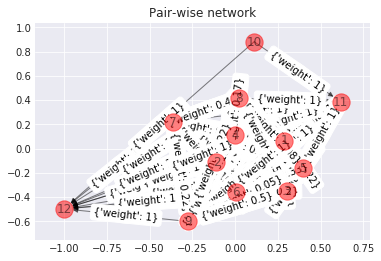

Before sorting: 
 {2: 0.04795797951927209, 1: 0.04329255233366864, 3: 0.07246048217822179, 4: 0.05891367792272171, 5: 0.05777424475366768, 6: 0.05927296300989563, 7: 0.07769160519957924, 8: 0.08355814597926924, 9: 0.09452896304524808, 12: 0.24330132126831325, 10: 0.029733647722412427, 11: 0.13151441706772998}
After sorting: 
 [(12, 0.24330132126831325), (11, 0.13151441706772998), (9, 0.09452896304524808), (8, 0.08355814597926924), (7, 0.07769160519957924), (3, 0.07246048217822179), (6, 0.05927296300989563), (4, 0.05891367792272171), (5, 0.05777424475366768), (2, 0.04795797951927209), (1, 0.04329255233366864), (10, 0.029733647722412427)]


,AppID,CompID,Department,EventID,FilterPath,FunctionArea,ID,Month,Quarter,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,DocumentPosition,DocumentID
20,1,349,NaN,164,NaN,NaN,da86fb3f-e1f5-4c75-a224-2b966eee7e11,12,4,AVG,1,20181202,1,2018-12-02T19:44:22.084Z,9007,183655,48,2018,1618770535846510593,[1],[1748359]
34,1,341,NaN,164,NaN,NaN,48cea54e-6728-4a6c-bc10-eb0f41710169,1,1,AVG,1,20190123,1,2019-01-23T10:42:31.990Z,9591,153094,4,2019,1623447465371893760,"[59, 61, 81, 107, 100]","[31022053, 31022063, 30957255, 30885142, 30883..."
38,1,379,NaN,164,NaN,NaN,70de62d1-ee47-4d5c-98b8-fecae5ed276f,1,1,AVG,1,20190124,1,2019-01-24T10:44:14.044Z,9474,97679,4,2019,1623538195853475840,"[25, 15]","[31944958, 31962962]"
51,1,379,NaN,164,NaN,NaN,9a0f5152-f806-49b0-ad73-5ec00f876a7d,1,1,AVG,1,20190130,1,2019-01-30T21:10:18.237Z,9575,152634,5,2019,1624121179038023680,"[1, 1]","[4109476, 18208689]"
63,1,349,NaN,164,NaN,NaN,a48b571b-2d9d-4e1e-8b59-d69a2da4a9fd,2,1,AVG,1,20190212,1,2019-02-12T09:41:20.958Z,10153,42244,7,2019,1625255554961113088,"[2, 7, 21]","[32132050, 31406576, 31792179]"
83,1,349,NaN,164,NaN,NaN,9bf3520b-8a77-40dd-91cc-e691e4128a1e,1,1,AVG,1,20190128,1,2019-01-28T20:40:32.819Z,9894,211403,5,2019,1623938073829048320,"[2, 1, 2]","[31518637, 31405957, 31518637]"
104,1,341,NaN,164,NaN,NaN,55f7fe4b-f0f3-4787-ba2f-c0d74f1b3481,12,4,AVG,1,20181231,1,2018-12-31T10:26:10.724Z,9300,16039,53,2018,1621362755432873985,[5],[31556981]
111,1,463,NaN,164,NaN,NaN,d5bb25d1-6411-4a3d-8be3-eb057c5e8caa,1,1,AVG,1,20190105,1,2019-01-05T11:47:22.172Z,9189,186770,1,2019,1621820807988641792,[1],[13151003]
114,1,444,NaN,164,NaN,NaN,4444e18c-a141-47c6-8dd4-8ccf41a39f00,1,1,AVG,1,20190115,1,2019-01-15T20:06:11.939Z,9233,196679,3,2019,1622758190033666048,"[63, 84]","[30898704, 31603735]"
118,1,444,NaN,164,NaN,NaN,b1b3af5c-c641-41cd-b000-b941cbb7666d,1,1,AVG,1,20190116,1,2019-01-16T10:02:22.555Z,9243,196727,3,2019,1622810759898595328,"[1, 1]","[23035590, 18208689]"


In [18]:
def start_search(query_str='AVG') -> pd.DataFrame:
    """
    :param: query_str query string to request clicks for 
    :return: DataFrame to 
    """
    
    print("Get dataframes: ")
    df_27 = get_27_frame(rows=10000000,from_disk=True)
    print("Got dataframe 27")
    df_164 = get_16_frame(search_text= query_str, rows=10000)
    print("Loaded both frames")
    
    display(df_27)
    display(df_164)

    df = check_and_concat(df_164=df_164, df_27=df_27)
    
    # Remove events that did not have a single click
    df = df[df['DocumentPosition'].str.len() != 0]
    df = df[pd.isna(df['FilterPath'])]

    
    print("shape dataframe", df.shape)
    
    # Make edges & construct relevance graph 
    edges = make_edges_r1(df, probs)
    
    # Display some edges
    edges[0][:10]
    create_relevance_graph(edges=edges)

    return df


df = start_search()
df

# df['DocumentPosition'].tolist()

# number = df.progress_apply(lambda x: [{click : [docid]} for click, docid in zip(df['DocumentPosition'].tolist(), df['DocumentID'].tolist())] , axis=1)

# df.to_hdf('./multiple_query/df27_{}'.format('Full concat'), key='test', mode='w')


In [9]:
df_27 = get_27_frame(rows=10000000,from_disk=True)
df_27 = df_27[(df_27['SearchText'] == 'AVG' ) | (df_27['SearchText'] == 'avg' )]

   
new_cols = ['UserID', 'DocumentID', 'DocumentPosition', 'DocumentURL', 'EventID', 'ID',
                   'SearchTypeID', 'ShortTimeStamp', 'TimeStamp', 'SearchText']

df_27 = df_27[new_cols]

df_27.sort_values(by=['DocumentPosition'])
df_27

,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText
1938341,231684,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,0f39a49e-4f7a-45ce-8274-fe7695627452,14.0,20190524,2019-05-24T13:52:20.020Z,AVG
1960064,99752,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,751321f0-98cb-4fd1-8a8c-6d161a917549,14.0,20190605,2019-06-05T11:40:48.248Z,avg
1944429,99752,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,8d993653-65c5-4fe6-b40c-9950b570fa76,14.0,20190605,2019-06-05T08:59:41.629Z,avg
2186133,191435,28455645,1,https://www.navigator.nl/#/document/idpass00fd...,27,c2ab37c8-08cd-4b67-8dc8-e445f243a3e1,14.0,20190628,2019-06-28T14:01:47.086Z,avg
1937529,31358,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,be7cd970-bf59-4a48-be37-bf296609f28a,14.0,20190524,2019-05-24T13:12:13.787Z,avg
1936293,96435,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,aed61903-35ae-4828-a910-f2bb951c5388,14.0,20190603,2019-06-03T14:30:27.332Z,AVG
1919765,97679,32038416,1,https://www.navigator.nl/#/document/id33a1f4a6...,27,015ea98d-48a1-4607-9c13-863d37c0d7b6,14.0,20190524,2019-05-24T09:22:51.944Z,avg
1902433,233168,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,211a3b21-f10e-4ad7-9a6d-1782c24a2d87,14.0,20190523,2019-05-23T14:37:53.605Z,AVG
1890871,221372,32038420,1,https://www.navigator.nl/#/document/idpass290b...,27,2112b75a-1317-4b42-9953-d045f839ca76,14.0,20190523,2019-05-23T11:14:43.713Z,AVG
1963401,231689,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,87a0332f-7ab5-44af-92ed-c355d3b8b3b9,14.0,20190603,2019-06-03T09:06:08.861Z,avg


,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText
1569688,126542,31070811,3,https://www.navigator.nl/#/document/idc9852f0c...,27,d18a26af-e5f9-426b-a6b2-21c55f8c4227,14.0,20190516,2019-05-16T12:23:33.020Z,avg
1571134,126542,31405957,8,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,4317ffa3-0830-4b10-bde7-898d438a1fad,14.0,20190516,2019-05-16T12:36:21.463Z,avg
1571140,126542,31518637,7,http://www.legalintelligence.com/documents/loc...,27,0b3487eb-8f2a-4bf7-a5a2-b3d358d8f94b,14.0,20190516,2019-05-16T12:36:48.579Z,avg
1571836,126542,31084583,5,https://www.navigator.nl/#/document/idbd3a235c...,27,ab7bb120-4cf9-46ad-b945-e6c9ebc6041a,14.0,20190516,2019-05-16T12:34:36.112Z,avg
1572246,179137,18208689,1,https://eur-lex.europa.eu/legal-content/NL/TXT...,27,30994bda-227e-4868-8641-947faafe4522,14.0,20190516,2019-05-16T11:17:43.352Z,avg
1577333,126542,27696874,14,http://www.legalintelligence.com/documents/loc...,27,6bb4a345-dcbe-4d19-9dba-d1a58e68f05b,14.0,20190516,2019-05-16T12:44:00.977Z,avg
1578685,126542,30364352,4,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,87701dda-df8c-46f9-8917-c3edf8ff1bdc,14.0,20190516,2019-05-16T12:48:30.405Z,avg
1580026,126542,30364352,4,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,00648fc1-0d7d-4af8-9850-65068f37c94c,14.0,20190516,2019-05-16T15:11:04.720Z,avg
1580188,126542,31847082,1,http://www.legalintelligence.com/documents/loc...,27,54b7b4d2-7498-4a5c-908c-95c5d4f7dcc5,14.0,20190516,2019-05-16T13:02:38.936Z,avg
1581586,126542,30742917,9,http://www.legalintelligence.com/documents/loc...,27,b7ef5555-9c0d-452b-af9b-beed09bd2db5,14.0,20190516,2019-05-16T12:42:54.771Z,avg


In [10]:
for i in tqdm(range(1,1000)):
    pass

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))